In [94]:
from qiskit import *
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import QuantumCircuit

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

from typing import Optional

import numpy as np
from random import *

In [95]:
def create_circuit(state: str, delay: int, basis: Optional[dict] = {0: 'z'}, plus_minus: Optional[dict] = {0: 'z'}) -> QuantumCircuit:
    """For BB84, we take state to be '0', '1', '+', '-' """
    """basis will be of the form -> {0: 'x', 1: 'z'}, i.e., the qubit number followed
    by the basis of measurement"""
    
    qc = QuantumCircuit(1)
    
    # create the appropriate start state
    if state[0] == '1':
        qc.x(0)
    if state[0] == '+':
        qc.h(0)
    if state[0] == '-':
        qc.x(0)
        qc.h(0)
    
    # apply the delay
    qc.delay(delay, unit='ns')
    
    # apply the appropriate basis rotation
    for qubit, rot in basis.items():
        if qubit > 1:
            raise ValueError('Provided qubit number exceeds the number of qubits in the circuit')
        else:
            if rot == 'x' or rot == 'X':
                qc.h(qubit)
            elif rot == 'y' or rot == 'Y':
                qc.sdg(qubit)
                qc.h(qubit)
                
    # apply the Hadamard to obtain + and - state
    for gate, hadamard in plus_minus.items():
        if gate > 1:
            raise ValueError('Provided H Gate number exceeds in the circuit for + or - State')
        else:
            if hadamard == 'h' or hadamard == 'H':
                qc.h(qubit)
    
    # final measurement
    qc.measure_all()
    
    return qc

In [96]:
print(create_circuit('1',100))

        ┌───┐┌────────────────┐ ░ ┌─┐
     q: ┤ X ├┤ Delay(100[ns]) ├─░─┤M├
        └───┘└────────────────┘ ░ └╥┘
meas: 1/═══════════════════════════╩═
                                   0 


In [97]:
print(create_circuit('-',100,{0: 'z'},{0: 'h'}))

        ┌───┐┌───┐┌────────────────┐┌───┐ ░ ┌─┐
     q: ┤ X ├┤ H ├┤ Delay(100[ns]) ├┤ H ├─░─┤M├
        └───┘└───┘└────────────────┘└───┘ ░ └╥┘
meas: 1/═════════════════════════════════════╩═
                                             0 


In [98]:
def make_noise(noise_params: dict, delay: int, q1_gate_len: int,
               q2_gate_len: int, measure_len: int, apply_error: dict) -> NoiseModel:
    """noise params contains the values of T1, T2"""
    """1q_gate_len, 2q_gate_len, measure_len gives the duration of each"""
    """apply_error -> {"delay": bool, "measure": bool, "gate": bool} -> states which errors are on"""
    
    noise_model = NoiseModel()
    
    if apply_error["delay"]:
        thermal_delay = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],delay)
        noise_model.add_all_qubit_quantum_error(thermal_delay,"delay")
        
    if apply_error["measure"]:
        thermal_measure = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],measure_len)
        noise_model.add_all_qubit_quantum_error(thermal_measure,"measure")
    
    if apply_error["gate"]:
        thermal_gate_1q = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],q1_gate_len)
        noise_model.add_all_qubit_quantum_error(thermal_gate_1q,["x","h","id"])
        
    
    return noise_model

In [99]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 3000, 5000,
          {"delay":True, "measure": True, "gate": True})

<NoiseModel on ['h', 'delay', 'measure', 'id', 'x']>

In [100]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 3000, 5000,
          {"delay":True, "measure": True, "gate": False})

<NoiseModel on ['delay', 'measure']>

In [101]:
noise_params = {"T1":193020, "T2":257470} # ibmq_armonk T1: 193.02 , T2:257.47 us
q1_gate_len = 200 # couldn't find
q2_gate_len = 405.33 # ibmq_armonk   x: 2.280e-4 
measure_len = 4977.778 # ibmq_armonk  4977.778 

In [102]:
def run(channel: str, delay: int, apply_error: dict, shots: Optional[int] = 1000) -> float:
    """Returns the probability of success for BB84 protocol"""
    """Channel: 1 => |0>+|1>, 2 => |0>+|1> 3 =>|0>+|1>  4=>|0>+|1> """
    
    if channel == '1':
        state = '0'
    elif channel == '2':
        state = '1'
    elif channel == '3':
        state = '+'
    elif channel == '4':
        state = '-'  
    
    qc = create_circuit(state,delay)
    backend = AerSimulator(noise_model=make_noise(noise_params,delay,q1_gate_len,q2_gate_len,measure_len,apply_error))
    counts = backend.run(qc,shots=shots).result().get_counts()
    #print(counts)
    success = 0
    
    if channel == '1':
        if '0' in counts.keys():
            success += counts['0']
        else:
            success +=0
#         if '1' in counts.keys():
#             success += counts['1']
    elif channel == '2':
        #if '0' in counts.keys():
            #success += counts['0']
        if '1' in counts.keys():
            success += counts['1']
        else:
            success +=0
    elif channel == '3':
        #if '0' in counts.keys():
            #success += counts['0']
        if '1' in counts.keys():
            success += counts['1']+500
        else:
            success +=500
    elif channel == '4':
        #if '0' in counts.keys():
            #success += counts['0']
        if '1' in counts.keys():
            success += counts['1']+500
        else:
            success +=500
            
    
    return float(success/shots)

In [103]:
run('2',1000,{"delay": True, "measure": True, "gate": True})

0.966

In [104]:
run('1',1000,{"delay": True, "measure": True, "gate": True})

1.0

In [105]:
run('3',1000,{"delay": True, "measure": True, "gate": True})

0.98

In [106]:
run('4',1000,{"delay": True, "measure": True, "gate": True})

0.959

# Probability of Success Graph

In [107]:
import matplotlib.pyplot as plt

delay = np.arange(0,10001000,1000)
channel = '1'
apply_error = {"delay":True, "measure": True, "gate": True}
success = []

# need to run in multiple loops to get a smoother curve
for d in range(len(delay)):
    prob = run(channel,int(delay[d]),apply_error)
    success.append(prob)

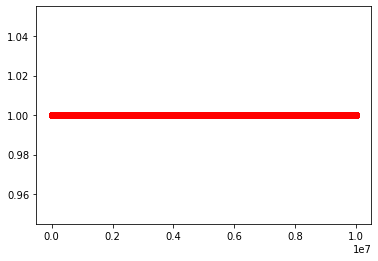

In [108]:
plt.plot(delay,success,'ro--')
plt.show()

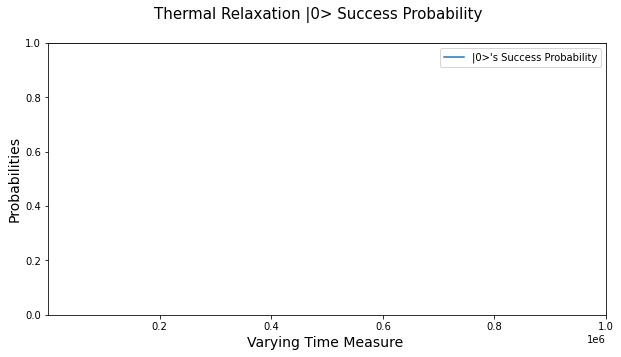

<Figure size 576x360 with 0 Axes>

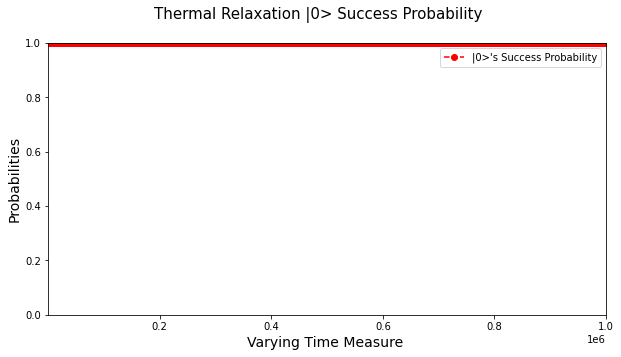

<Figure size 576x360 with 0 Axes>

In [109]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |0> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,label = "|0>'s Success Probability")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |0> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,'ro--',label = "|0>'s Success Probability")
ax.legend()

In [110]:
import matplotlib.pyplot as plt

delay = np.arange(0,10001000,1000)
channel = '2'
apply_error = {"delay":True, "measure": True, "gate": True}
success = []

# need to run in multiple loops to get a smoother curve
for d in range(len(delay)):
    prob = run(channel,int(delay[d]),apply_error)
    success.append(prob)

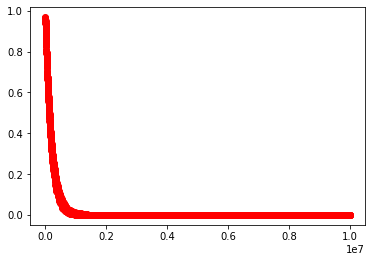

In [111]:
plt.plot(delay,success,'ro--')
plt.show()

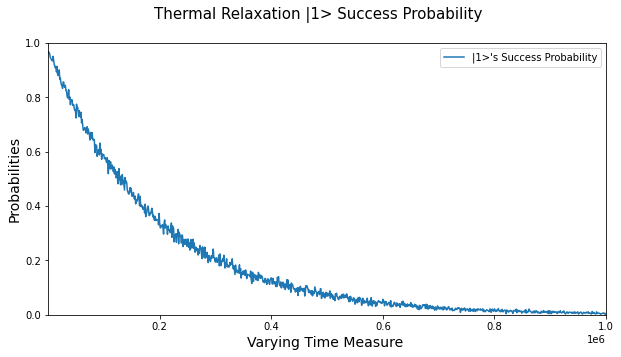

<Figure size 576x360 with 0 Axes>

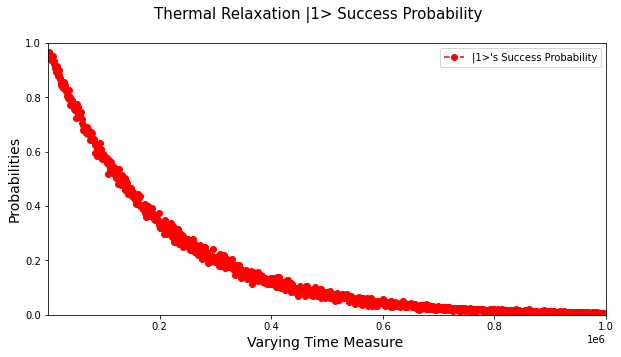

<Figure size 576x360 with 0 Axes>

In [112]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |1> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,label = "|1>'s Success Probability")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |1> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,'ro--',label = "|1>'s Success Probability")
ax.legend()

In [113]:
import matplotlib.pyplot as plt

delay = np.arange(0,10001000,1000)
channel = '3'
apply_error = {"delay":True, "measure": True, "gate": True}
success = []

# need to run in multiple loops to get a smoother curve
for d in range(len(delay)):
    prob = run(channel,int(delay[d]),apply_error)
    success.append(prob)

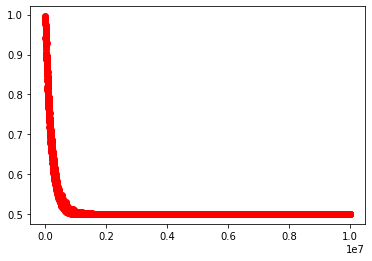

In [114]:
plt.plot(delay,success,'ro--')
plt.show()

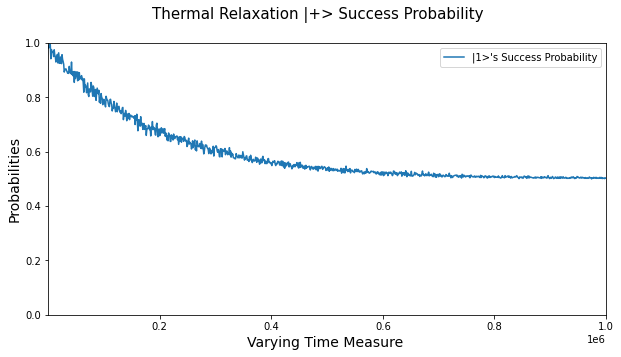

<Figure size 576x360 with 0 Axes>

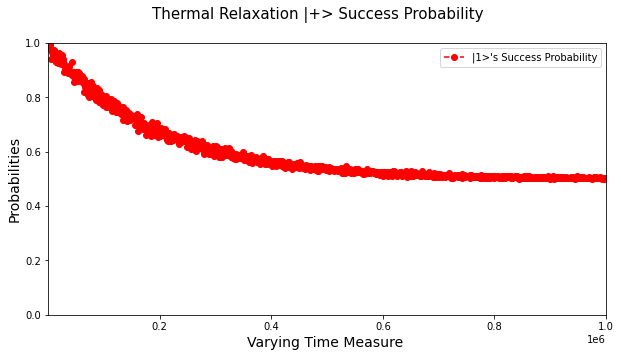

<Figure size 576x360 with 0 Axes>

In [115]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |+> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,label = "|1>'s Success Probability")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |+> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,'ro--',label = "|1>'s Success Probability")
ax.legend()

In [116]:
delay = np.arange(0,1001000,1000)
channel = '4'
apply_error = {"delay":True, "measure": True, "gate": False}
success = []

# need to run in multiple loops to get a smoother curve
for d in range(len(delay)):
    prob = run(channel,int(delay[d]),apply_error)
    success.append(prob)

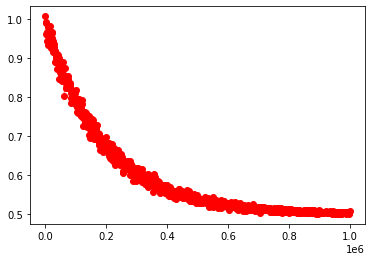

In [117]:
plt.plot(delay,success,'ro--')
plt.show()

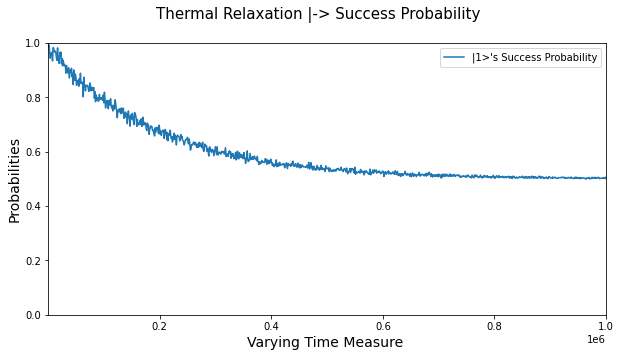

<Figure size 576x360 with 0 Axes>

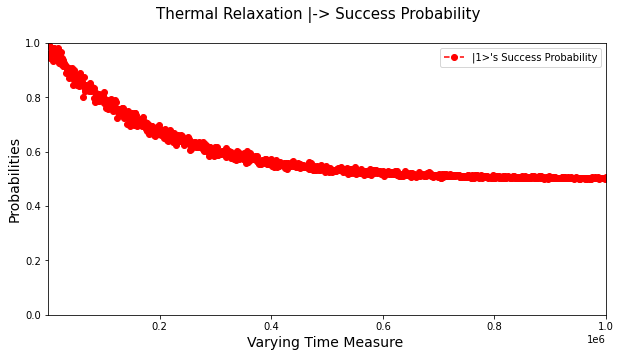

<Figure size 576x360 with 0 Axes>

In [118]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |-> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,label = "|1>'s Success Probability")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |-> Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,'ro--',label = "|1>'s Success Probability")
ax.legend()

In [120]:
# from statistics import mean
# a= y
# print(*map(mean, zip(*a)))